## **A quick flight to the edge of Data Science: Tidy Modelling with R**




### Meet the data

In this sections, we'll build a multiclass classifier for classifying penguins!

The `palmerpenguins` data contains size measurements for three penguin species observed on three islands in the Palmer Archipelago, Antarctica.


### A quick look at the data


In [52]:
# Load the required packages and make them available in your current R session
suppressPackageStartupMessages({
  library(tidyverse)
  library(tidymodels)
})

# Import data
penguins <- read_csv("penguins.csv", show_col_types = FALSE) %>% 
  mutate(species = factor(species))

# View the first 10 observations
penguins %>%
  slice_head(n = 10)

dim(penguins)

bill_length_mm bill_depth_mm flipper_length_mm body_mass_g species
1  39.1           18.7          181               3750        Adelie 
2  39.5           17.4          186               3800        Adelie 
3  40.3           18.0          195               3250        Adelie 
4  36.7           19.3          193               3450        Adelie 
5  39.3           20.6          190               3650        Adelie 
6  38.9           17.8          181               3625        Adelie 
7  39.2           19.6          195               4675        Adelie 
8  34.1           18.1          193               3475        Adelie 
9  42.0           20.2          190               4250        Adelie 
10 37.8           17.1          186               3300        Adelie

[1] 342   5

The data contains the following columns:


The **species** column containing penguin species `Adelie`, `Chinstrap`, or `Gentoo`, is the label we want to train a model to predict.




In [53]:
# Check missing values
anyNA(penguins)


[1] FALSE

No missing values. Good start!

For brevity, let's make one exploratory plot.



species   predictors        values
1  Chinstrap body_mass_g       3700.0
2  Gentoo    body_mass_g       5850.0
3  Adelie    bill_length_mm      35.3
4  Gentoo    bill_depth_mm       16.0
5  Gentoo    bill_length_mm      50.0
6  Gentoo    bill_depth_mm       14.5
7  Gentoo    flipper_length_mm  212.0
8  Adelie    flipper_length_mm  185.0
9  Adelie    flipper_length_mm  195.0
10 Gentoo    flipper_length_mm  210.0

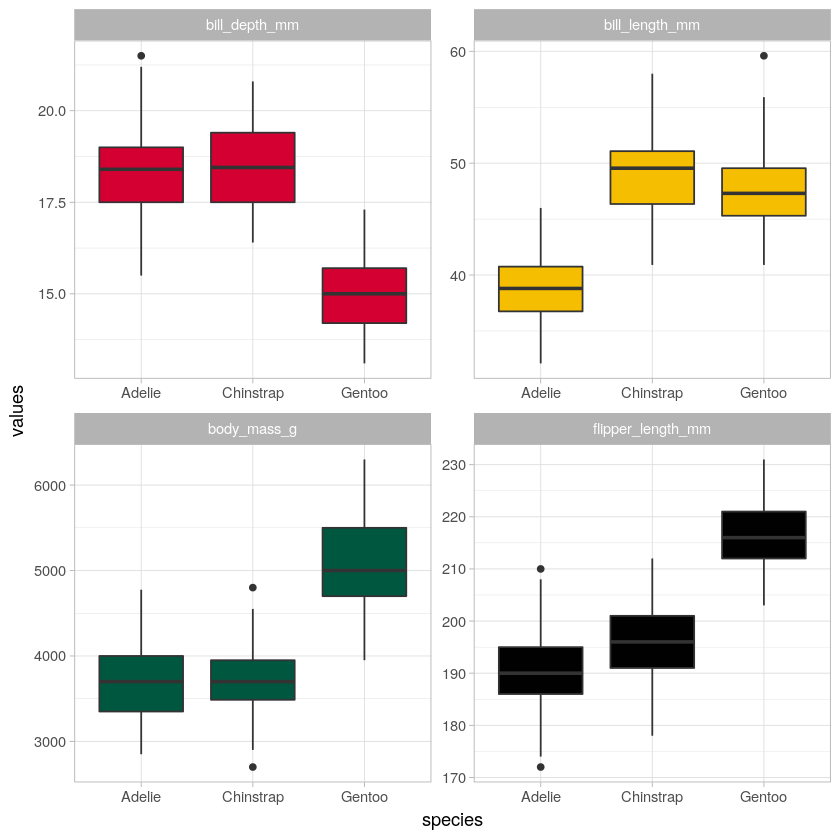

In [54]:
# Pivot data to a long format
penguins_select_long <- penguins %>% 
  pivot_longer(!species, names_to = "predictors", values_to = "values")

penguins_select_long %>% 
  slice_sample(n = 10)

# Make box plots
theme_set(theme_light())
penguins_select_long %>%
  ggplot(mapping = aes(x = species, y = values, fill = predictors)) +
  geom_boxplot() +
  facet_wrap(~predictors, scales = "free") +
  paletteer::scale_fill_paletteer_d("nbapalettes::supersonics_holiday") +
  theme(legend.position = "none")
  


From the box plots, it looks like species `Adelie` and `Chinstrap` have similar data profiles for bill_depth, flipper_length, and body_mass, but Chinstraps tend to have longer bill_length. `Gentoo` tends to have fairly clearly differentiated features from the others; which should help us train a good classification model.

## Build a model

### 1. Data budgeting

To get started, let‚Äôs split this single dataset into two: a training set and a testing set. We‚Äôll keep most of the rows in the original dataset (subset chosen randomly) in the training set. The training data will be used to fit the model, and the testing set will be used to measure model performance.


In [15]:
# For reproducibility
set.seed(2056)

# Split data 70%-30% into training set and test set
penguins_split <- penguins %>% 
  initial_split(prop = 0.70)

# Extract data in each split
penguins_train <- training(penguins_split)
penguins_test <- testing(penguins_split)

# Print the number of observations in each split
cat("Training cases: ", nrow(penguins_train), "\n",
    "Test cases: ", nrow(penguins_test), sep = "")


Training cases: 239
Test cases: 103

### 2. Make a model specifcation

<p >
<center><img src = "images/parsnip.png", width= 500>
<figcaption>Artwork by @allison_horst</figcaption>




Tidymodels provides a unified interface to models that can be used to try a range of models by specifying three concepts:

- Model **type** differentiates models such as logistic regression, decision tree models, and so forth.

- Model **engine** is the computational tool which will be used to fit the model. Often these are R packages, such as "lm" or "ranger"

- Model **mode** includes common options like regression and classification; some model types support either of these while some only have one mode.

In [55]:
# Specify a random forest model via ranger
rf_spec <- rand_forest() %>% 
  set_engine("ranger") %>% 
  set_mode("classification")

print(rf_spec)

Random Forest Model Specification (classification)

Computational engine: ranger 



In [62]:
# Specify a multinomial logistic regression model via nnet
rf_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet") %>% 
  set_mode("classification")

print(rf_spec)

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Computational engine: nnet 



### 3. Train a model

Now that your `penguins_train` data is ready, you can fit a set of models with tidymodels.

In [63]:
# Train a regression model
set.seed(2056)
penguins_mod <- rf_spec %>% 
  fit(species ~ ., data = penguins_train)

# Print the model
print(penguins_mod)

parsnip model object

Fit time:  10ms 
Call:
nnet::multinom(formula = species ~ ., data = data, decay = ~1, 
    trace = FALSE)

Coefficients:
          (Intercept) bill_length_mm bill_depth_mm flipper_length_mm
Chinstrap -0.06882423      1.4164181    -0.6972606     -0.1764658531
Gentoo    -0.03358640      0.2879962    -1.6844767      0.0004180132
          body_mass_g
Chinstrap -0.00421942
Gentoo     0.00350662

Residual Deviance: 29.95049 
AIC: 49.95049 


### 4. Evaluate Model using test data

Now we can use the trained model to predict the labels for the test features, and evaluate performance. When making predictions, the tidymodels convention is to always produce a tibble of results with standardized column names.



In [64]:
# Make predictions for the test set
penguins_pred <- penguins_mod %>% 
  predict(new_data = penguins_test)

penguins_pred %>% 
  slice_head(n = 10)

.pred_class
1  Adelie     
2  Adelie     
3  Adelie     
4  Adelie     
5  Adelie     
6  Adelie     
7  Adelie     
8  Adelie     
9  Adelie     
10 Adelie

This makes it easy to combine the original data and the predictions in a usable format:

In [65]:
# Combine predictions with test set
penguins_results <- penguins_test %>% 
  bind_cols(penguins_pred)

# Print predictions
penguins_results %>% 
  slice_sample(n = 10)



bill_length_mm bill_depth_mm flipper_length_mm body_mass_g species  
1  37.8           18.3          174               3400        Adelie   
2  46.2           14.1          217               4375        Gentoo   
3  42.8           14.2          209               4700        Gentoo   
4  44.0           13.6          208               4350        Gentoo   
5  34.0           17.1          185               3400        Adelie   
6  40.8           18.4          195               3900        Adelie   
7  42.5           16.7          187               3350        Chinstrap
8  49.6           16.0          225               5700        Gentoo   
9  38.5           17.9          190               3325        Adelie   
10 46.7           15.3          219               5200        Gentoo   
   .pred_class
1  Adelie     
2  Gentoo     
3  Gentoo     
4  Gentoo     
5  Adelie     
6  Adelie     
7  Chinstrap  
8  Gentoo     
9  Adelie     
10 Gentoo

Now, let's look at the confusion matrix for our model



In [66]:
# Confusion matrix
penguins_results %>% 
  conf_mat(truth = species, estimate = .pred_class) %>% 
  print()


           Truth
Prediction  Adelie Chinstrap Gentoo
  Adelie        48         1      0
  Chinstrap      0        19      0
  Gentoo         0         0     35


The confusion matrix shows the intersection of predicted and actual label values for each class - in simple terms, the diagonal intersections from top-left to bottom-right indicate the number of correct predictions.

When dealing with multiple classes, it's generally more intuitive to visualize this as a heat map, like this:


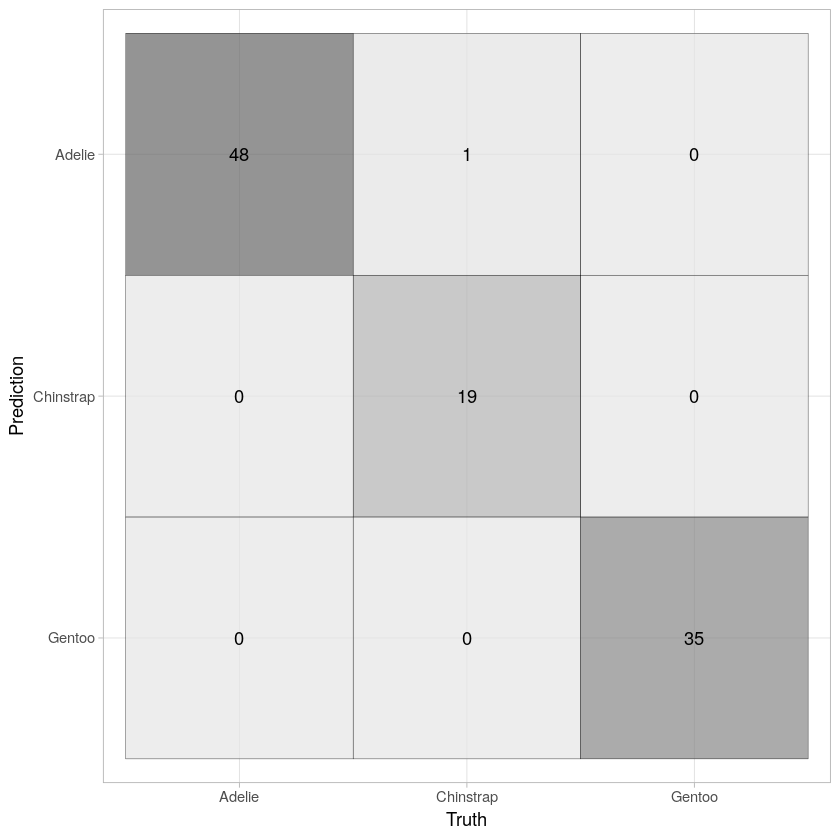

In [67]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
penguins_results %>% 
  conf_mat(species, .pred_class) %>% 
  autoplot(type = "heatmap")


The darker squares in the confusion matrix plot indicate high numbers of cases, and you can hopefully see a diagonal line of darker squares indicating cases where the predicted and actual label are the same.

Let's now calculate summary statistics for the confusion matrix.


Again, notice how the results of Tidymodels augment well with existing Tidy data Functions such as `Filter()`

In [68]:
# Statistical summaries for the confusion matrix
conf_mat(data = penguins_results, truth = species, estimate = .pred_class) %>% 
  summary()  %>% 
  filter(.metric %in% c("accuracy", "sens", "ppv"))


.metric  .estimator .estimate
1 accuracy multiclass 0.9902913
2 sens     macro      0.9833333
3 ppv      macro      0.9931973

The tibble shows the overall metrics of how well the model performs across all three classes.

Accuracy: The percentage of labels predicted accurately for a sample.

Sensitivity: defined as the proportion of positive results out of the number of samples which were actually positive.

Positive Predictive Value: defined as the proportion of predicted positives that are actually positive.








Good job! A working model üêßüêß! 
### **Wrapping up and next steps**

<p >
<img src = "images/giphy_p.gif", class = "center", width= 300>

Congratulations on building a random forest classification model in R. Some possible next steps (covered in the upcoming learning path) would be:

- Feature Engineering
- Tuning model hyperparameters
- Comparing performance across many models
- Deploying model to [Azure Machine Learning Studio](https://ml.azure.com/)

